In [1]:
import sys
sys.path.append('lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling

%reload_ext autoreload
%autoreload 2

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, -1, :, :, :].to(device) #only keeping the last frame of each sequence
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, -1, :, :, :].to(device)
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 3, 1, 2)
eval_data = eval_data.permute(0, 3, 1, 2)
#test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 64, 64, 3])
torch.Size([8000, 3, 64, 64])


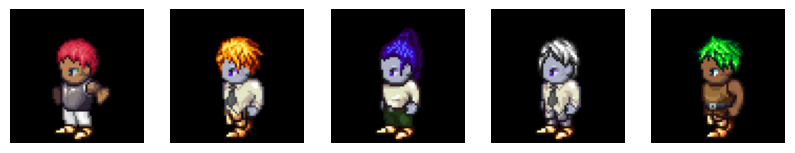

In [3]:
#check

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [4]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 5, "factor": 0.5})


Latent dim: 12


In [6]:
# config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# print(device)

# vae = VAE(model_config=config, encoder=encoder, decoder=decoder).to(device)

x = train_dataset[0:100]
# print(x.data.shape)
# x.data = x.data.unsqueeze(0)
# print(x.data.shape)
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-05-30_17-33-43-latdim12/final_model').to(device)
out = vae(x)
out['recon_x'].shape

torch.Size([100, 3, 64, 64])

In [ ]:
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


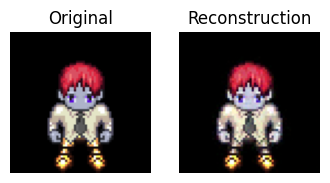

In [7]:
idx = 100
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

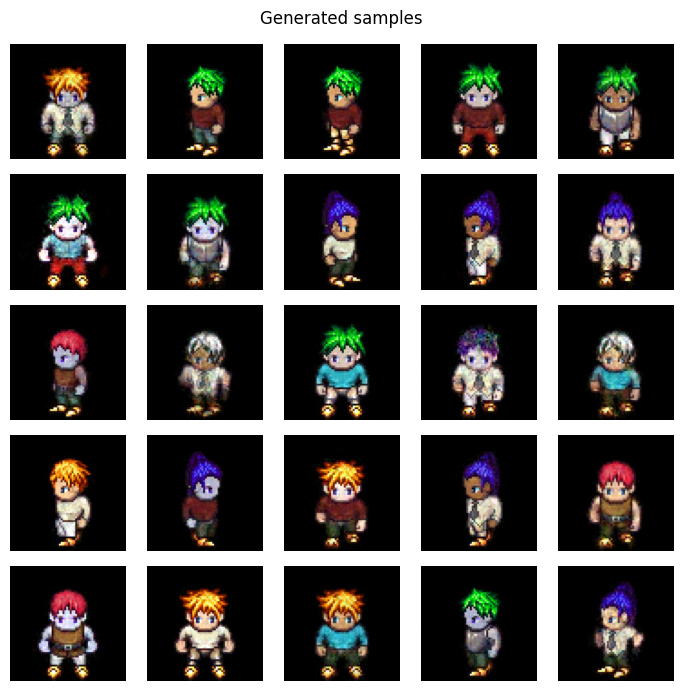

In [8]:
normal_sampler = NormalSampler(
    model=vae
)
gen_data = normal_sampler.sample(
    num_samples=25
)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7))
plt.suptitle('Generated samples')
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5+j].cpu().permute(1, 2, 0))
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

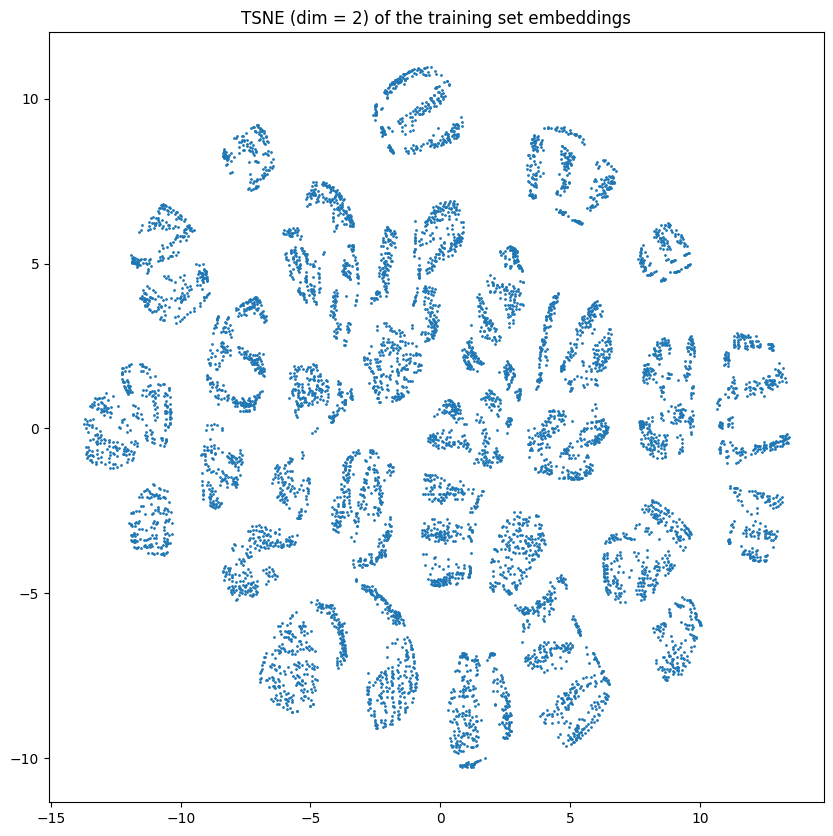

In [104]:
train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
train_tsne = tsne.fit_transform(train_embeddings.detach().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], s=1)
plt.title('TSNE (dim = 2) of the training set embeddings')
plt.show()


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
device = 'cuda'
vae = vae.to(device)

mu = []
log_var = []
with torch.no_grad():
    for _ , x in enumerate(train_loader):

        data = x.data

        out = vae.encoder(data.to(device))

        mu_data, log_var_data = out.embedding, out.log_covariance

        mu.append(mu_data)
        log_var.append(log_var_data)

mu = torch.cat(mu)
log_var = torch.cat(log_var)

In [12]:
print('Running Kmedoids')
print(device)
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=100).fit(mu.detach().cpu())
medoids = torch.tensor(kmedoids.cluster_centers_).to(device)
centroids_idx = kmedoids.medoid_indices_ #

Running Kmedoids
cuda


In [13]:
print("Finding temperature")
eps_lf = 0.01
lbd = 0.01
T = 0
T_is = []
for i in range(len(medoids)-1):
    mask = torch.tensor([k for k in range(len(medoids)) if k != i])
    dist = torch.norm(medoids[i].unsqueeze(0) - medoids[mask], dim=-1)
    T_i =torch.min(dist, dim=0)[0]
    T_is.append(T_i.item())

T = np.max(T_is)
print('Best temperature found: ', T)

print('Building metric')
vae = build_metrics(vae, mu, log_var, centroids_idx, T=T, lbd=lbd)

Finding temperature
Best temperature found:  1.8156673376871422
Building metric


In [15]:
n_samples = 1000
batch_size = 1000

all_z = []

device = 'cuda'
vae = vae.to(device)
mu = mu.to(device)

for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z.append(z)

p = p[0]

In [16]:
all_z = torch.cat(all_z, dim=0)
all_z.shape

torch.Size([1000, 12])

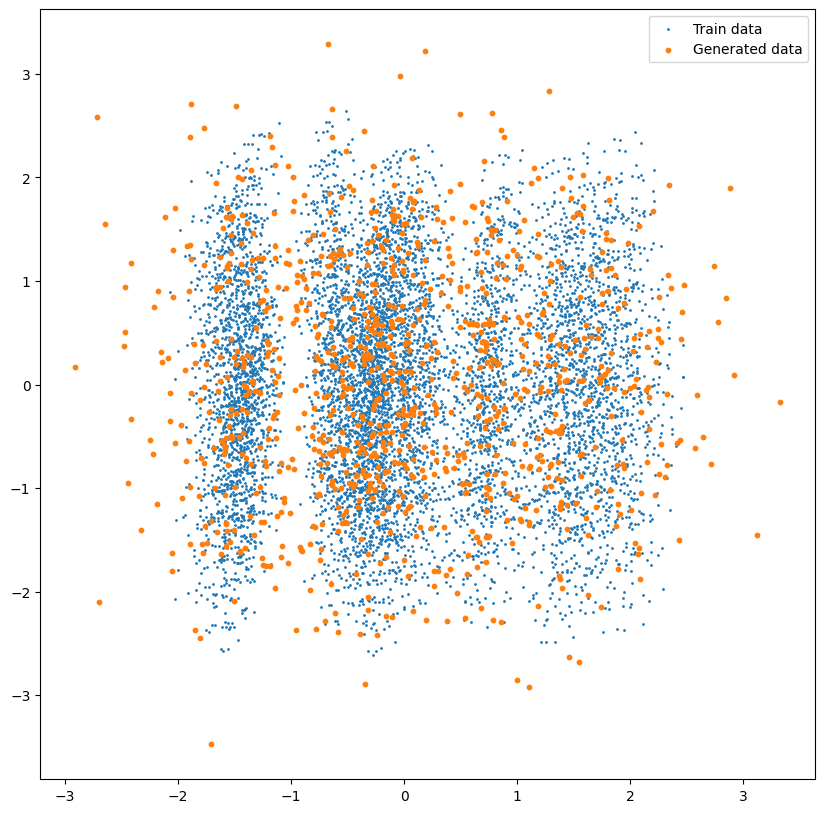

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
train_pca = pca.fit_transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
p_pca  = pca.transform(p.cpu().detach().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data')
#plt.scatter(p_pca[:, 0], p_pca[:, 1], s = 10, label='Path')
plt.legend()
plt.show()

In [21]:
torch.save(all_z, 'zT_samples.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

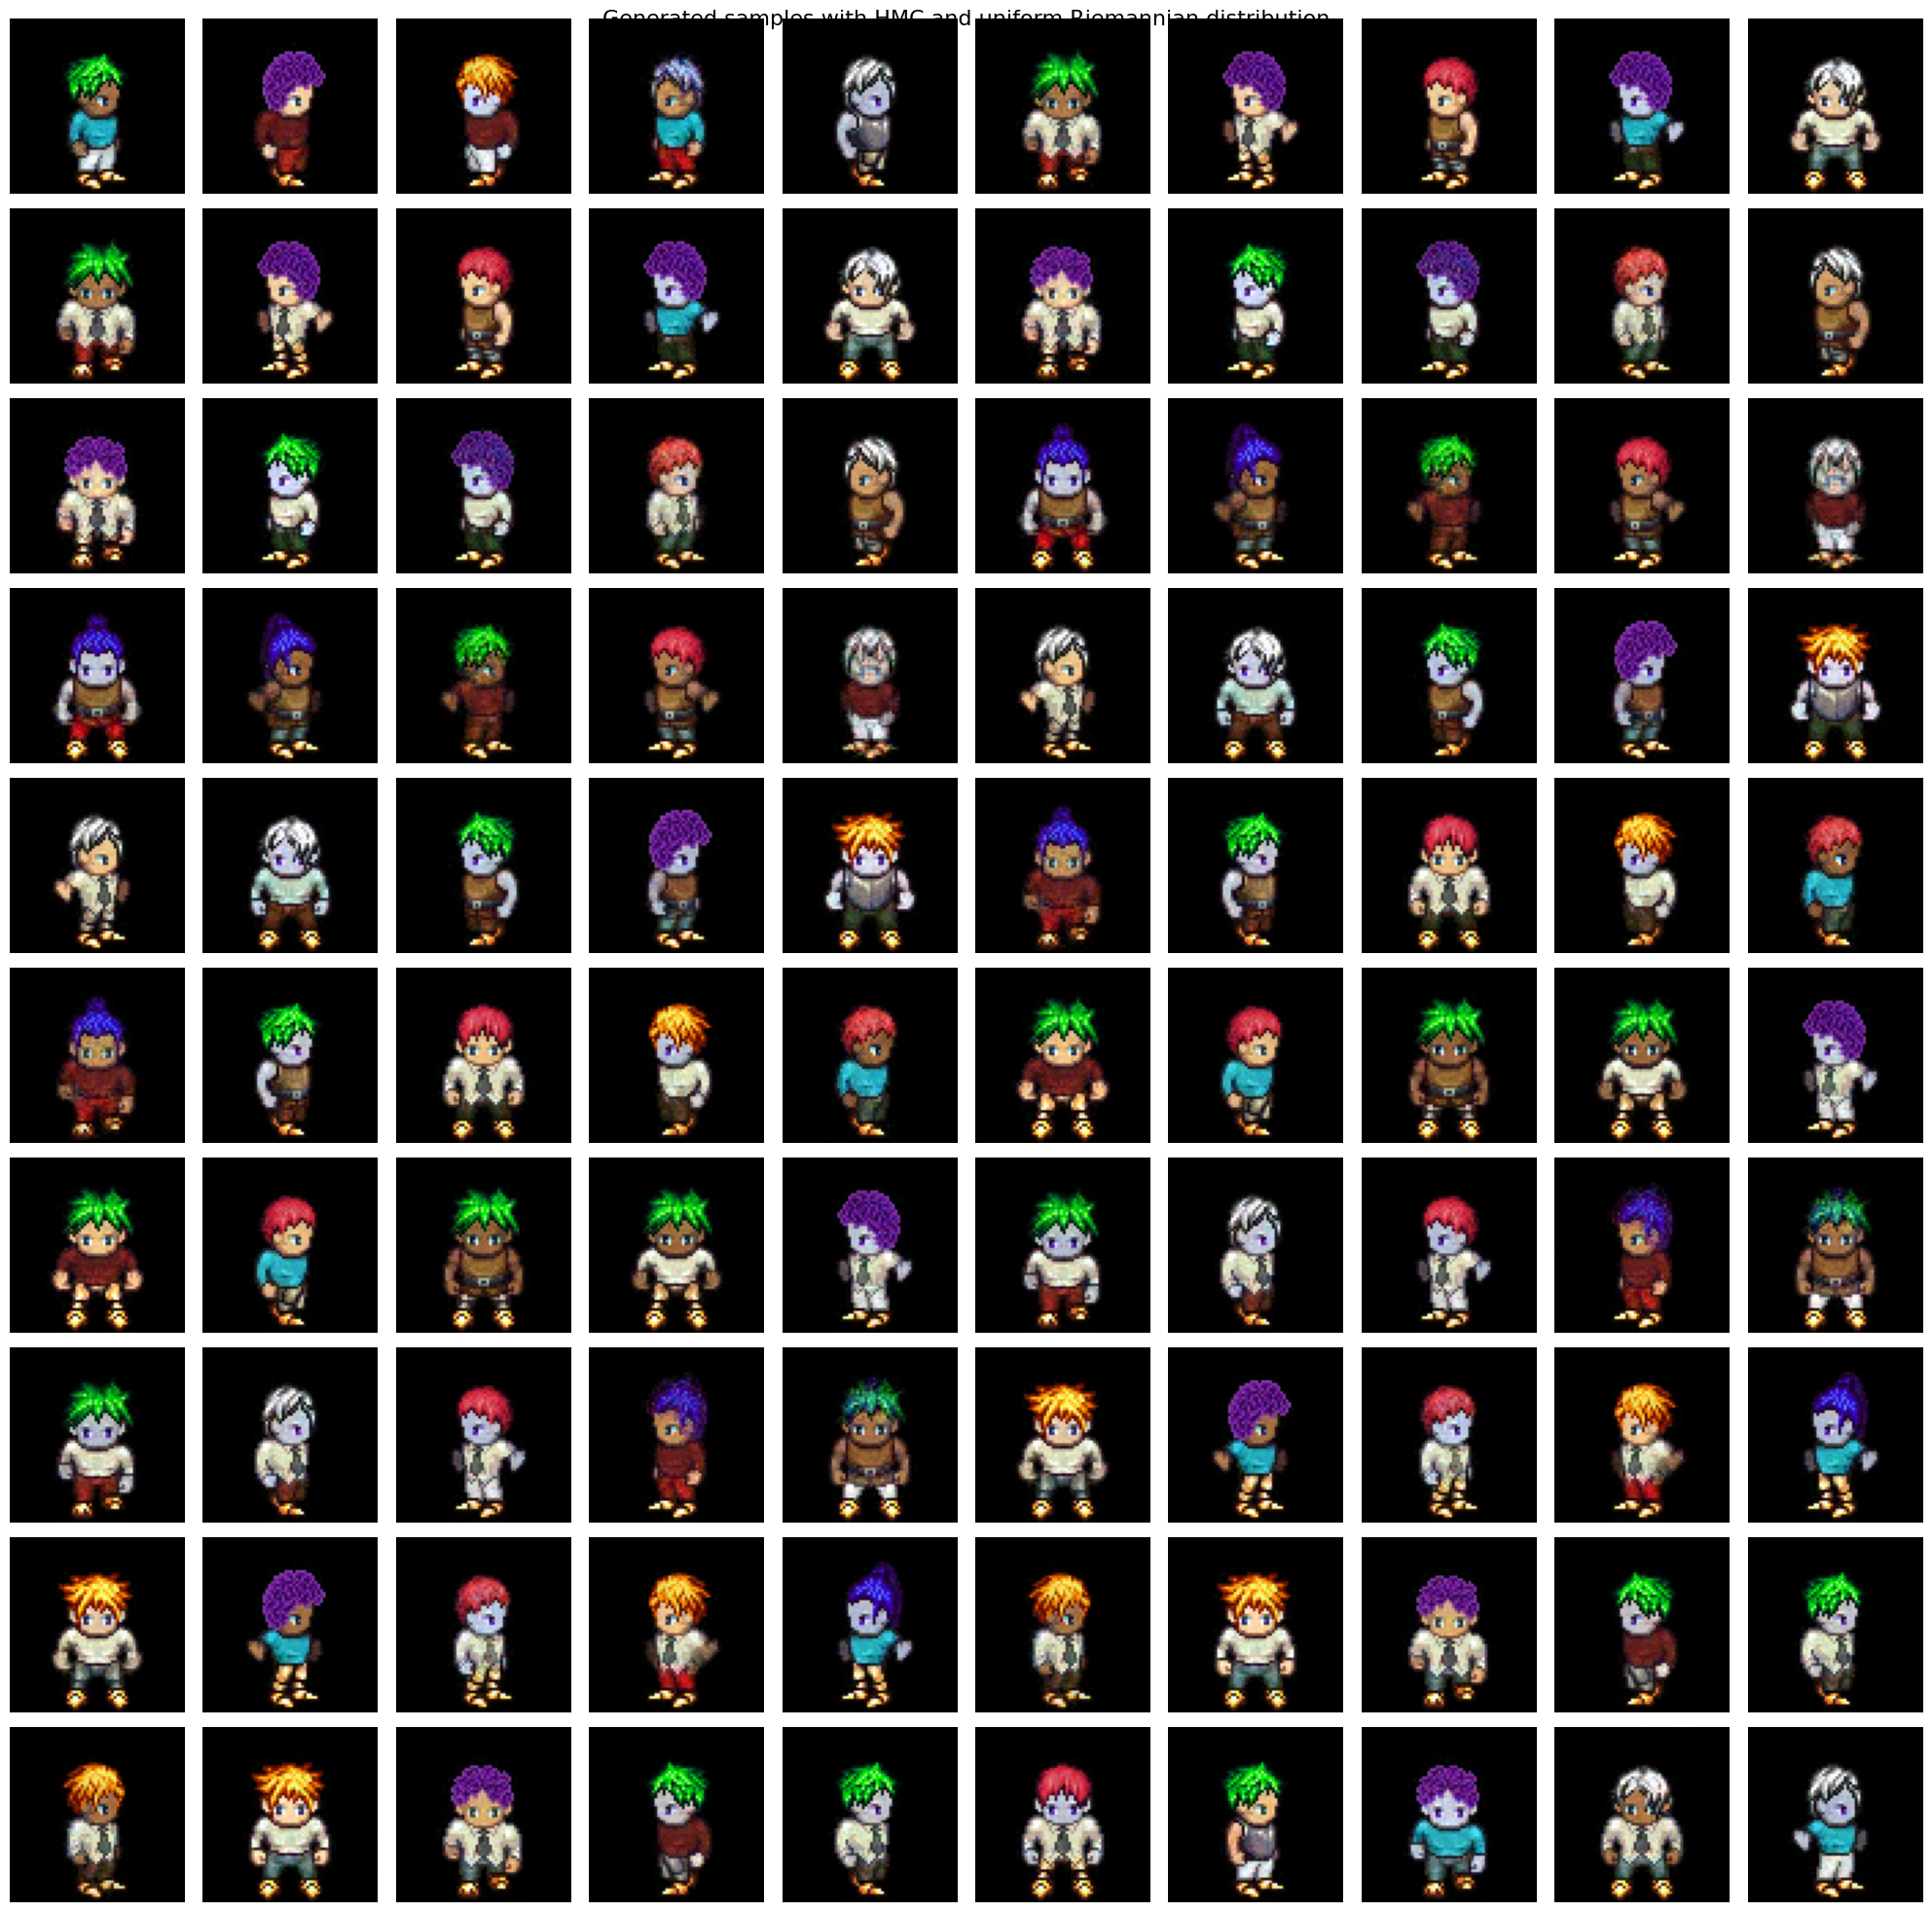

In [142]:
vae = vae.to('cpu')
all_z= all_z.to('cpu').detach()

gen_data = vae.decoder(all_z).reconstruction.detach()

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(gen_data[i*5+j].permute(1, 2, 0))
        axes[i][j].axis('off')

fig.suptitle('Generated samples with HMC and uniform Riemannian distribution', fontsize=16)
plt.tight_layout()
plt.show()